In [39]:
from climada.hazard import TCTracks, TropCyclone, Centroids

tracks_sync_1000yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt')

In [40]:
len(tracks_sync_1000yr.data)

1964

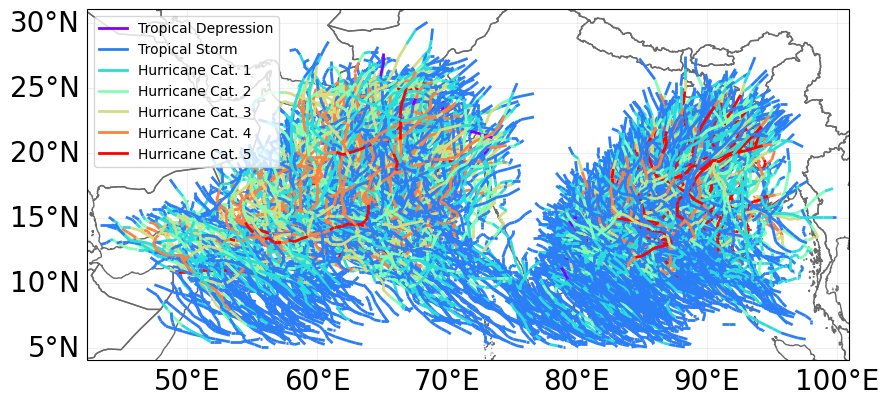

In [41]:
ax = tracks_sync_1000yr.plot()
ax.get_legend()._loc = 2

In [42]:
import pandas as pd
from climada.entity import Exposures

# Define exposrues here
file_name = 'exposures.xlsx'
exposures = pd.read_excel(file_name)

exp  = Exposures(exposures, ref_year=2024)
print(exp)

description: None
ref_year: 2024
value_unit: USD
crs: EPSG:4326
data: (95 entries)
           value  impf_TC                         Plant name  \
0   1.603000e+09        1          Adani Godda power station   
1   1.890239e+09        1     Aditya Aluminium power station   
2   3.784000e+07        1     Amravati Thermal Power Project   
3   4.742700e+08        1                Angul power station   
91  8.483000e+07        1  Visakhapatnam Sarda power station   
92  8.920050e+08        1          Vizag Thermal Power Plant   
93  2.812695e+09        1              Yadadri power station   
94  2.600000e+08        1             Yermarus power station   

                     geometry  
0   POINT (87.13546 24.81411)  
1   POINT (84.06059 21.74007)  
2   POINT (77.90124 21.08032)  
3   POINT (84.98055 21.12704)  
91  POINT (82.96136 17.46644)  
92  POINT (83.13888 17.56364)  
93  POINT (79.58118 16.70822)  
94  POINT (77.35612 16.29526)  


In [43]:
# Define the centroids from the exposures position
lat = exposures["latitude"].values
lon = exposures["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

In [45]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs)

321kKB [00:44, 7.24kKB/s]                           


In [46]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])

In [47]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [48]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True
) # Save the impact in a mat file

print(imp)

In [49]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 46822631774.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

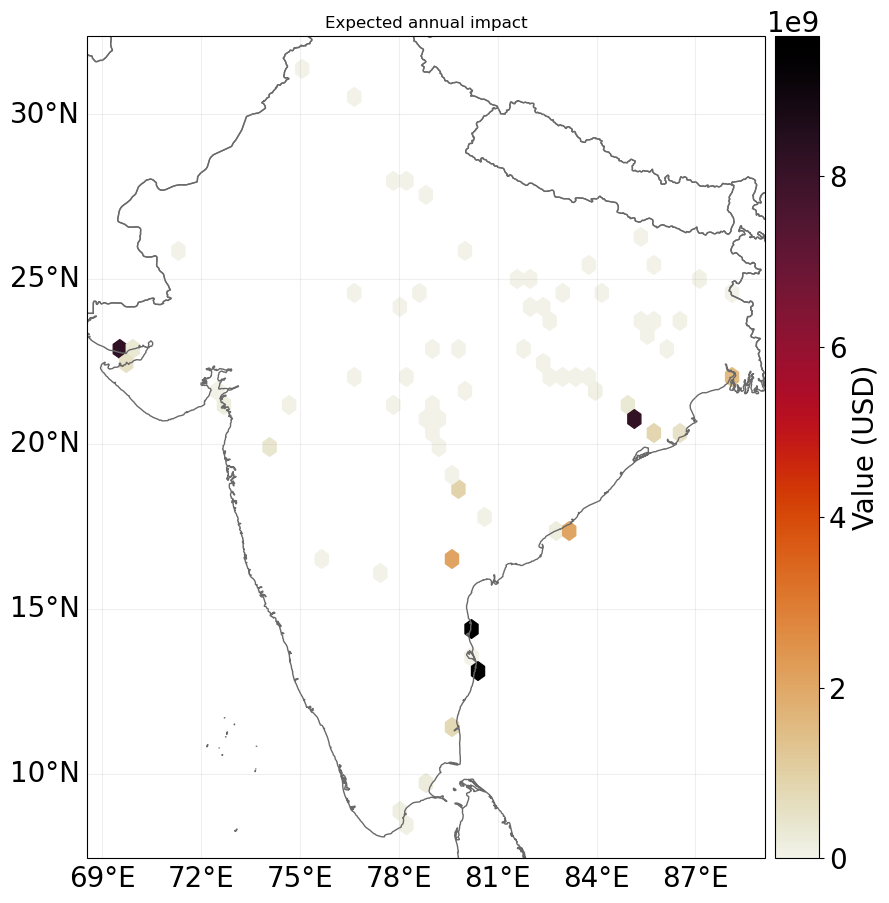

In [51]:
imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False)

In [ ]:
def impact_visual(data):

    tc = TropCyclone.from_tracks(data, centroids=centrs)
    impf_tc = ImpfTropCyclone.from_emanuel_usa()
    # add the impact function to an Impact function set
    impf_set = ImpactFuncSet([impf_tc])
    [haz_type] = impf_set.get_hazard_types()
    [haz_id] = impf_set.get_ids()[haz_type]
    imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True)
    print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

    return imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False)
    

Aggregated average annual impact: 46822631774.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

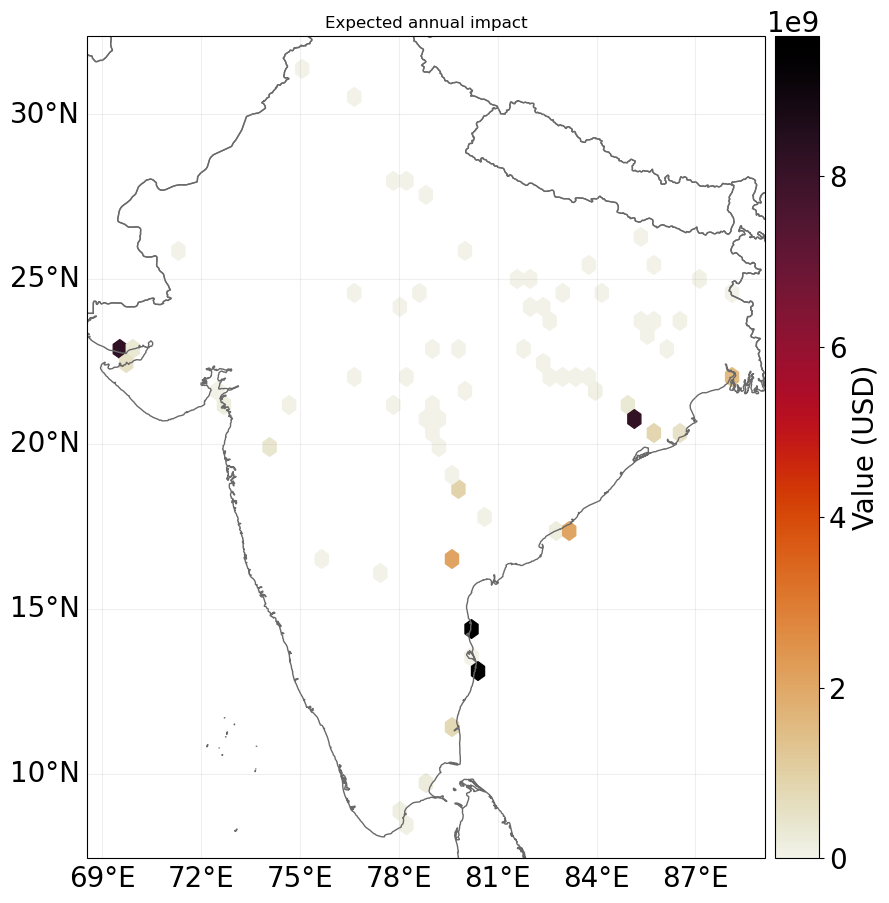

In [53]:
impact_visual(tracks_sync_1000yr)

In [96]:
# Generate 

RP5, RP10, RP100, RP200 =[], [], [], []

i=0
while i<=4:
    RP5.append(i)
    i+=1

i=0
while i<=9:
    RP10.append(i)
    i+=1

i=0
while i<=99:
    RP100.append(i)
    i+=1

i=0
while i<=199:
    RP200.append(i)
    i+=1

In [97]:
tracks_sync_5yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=RP5)

Aggregated average annual impact: 437736617.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

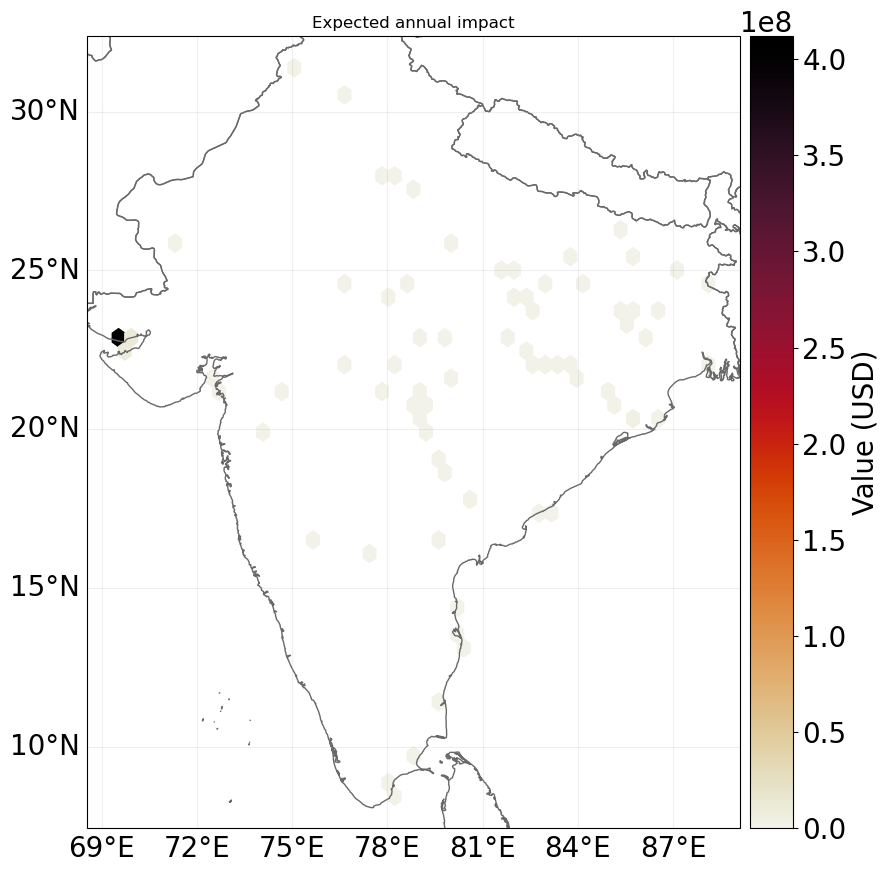

In [98]:
impact_visual(tracks_sync_5yr)

Aggregated average annual impact: 1244364553.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

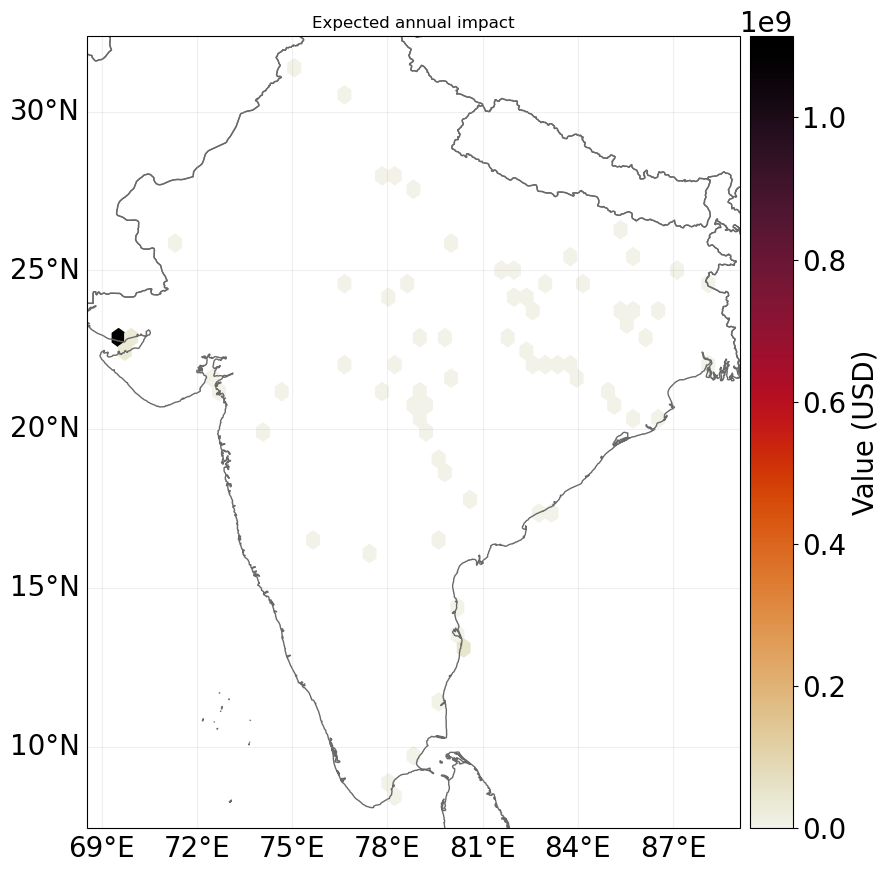

In [100]:
tracks_sync_10yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=RP10)
impact_visual(tracks_sync_10yr)

Aggregated average annual impact: 6646790659.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

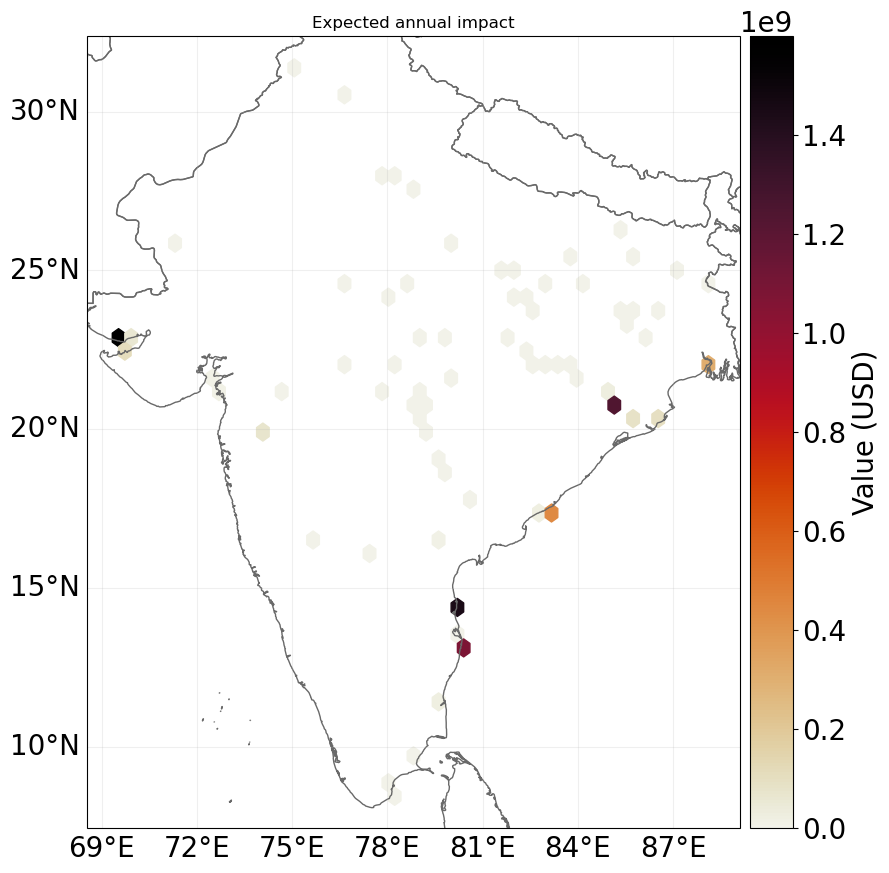

In [101]:
tracks_sync_100yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=RP100)
impact_visual(tracks_sync_100yr)

Aggregated average annual impact: 9286829972.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

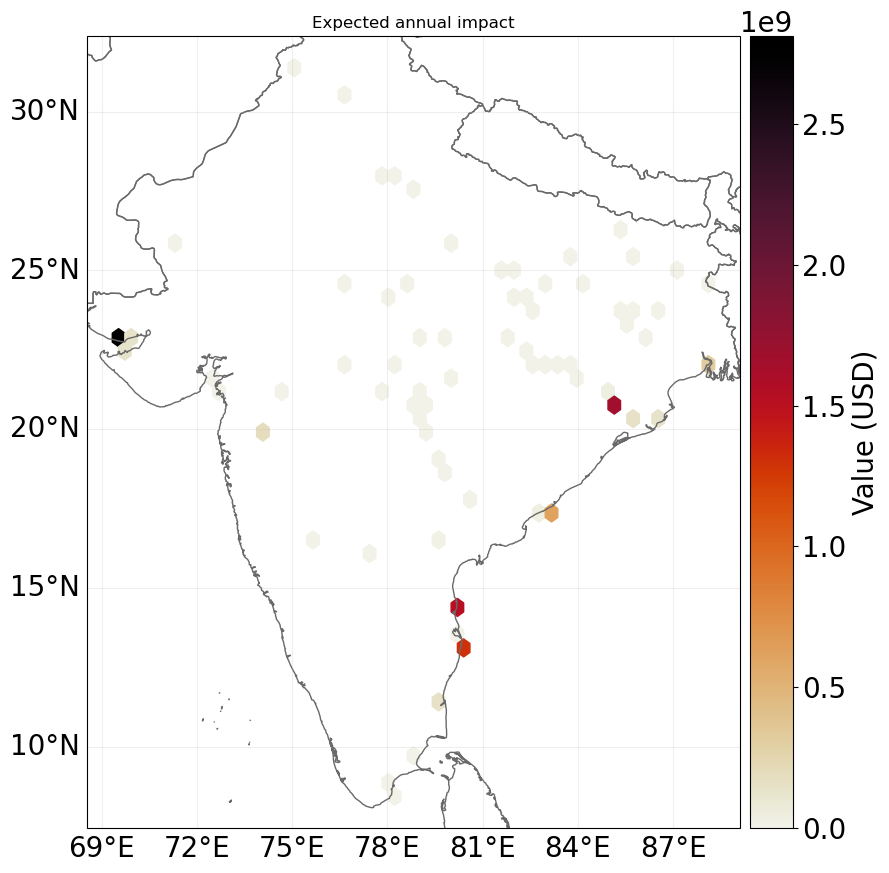

In [103]:
tracks_sync_200yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=RP200)
impact_visual(tracks_sync_200yr)